# ML Classifiers

**Goal:** Given a sentence as input, classify it as either a prediction or non-prediction.

In [1]:
import os
import sys
import warnings

import pandas as pd

from tqdm import tqdm

# Get the current working directory of the notebook
notebook_dir = os.getcwd()
# Add the parent directory to the system path
sys.path.append(os.path.join(notebook_dir, '../'))

# import log_files
from data_processing import DataProcessing
from feature_extraction import SpacyFeatureExtraction
# from classification_models import SkLearnPerceptronModel, SkLearnSGDClassifier, EvaluationMetric
from classification_models import SkLearnModelFactory
from metrics import EvaluationMetric

In [2]:
pd.set_option('max_colwidth', 800)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_columns', 40)
pd.set_option('display.max_rows', None)

warnings.filterwarnings('ignore')

## Load Data

In [3]:
print("======= LOAD DATA =======")

======= LOAD DATA =======


In [4]:
base_data_path = os.path.join(notebook_dir, '../data')
combine_data_path = os.path.join(base_data_path, 'financial_phrase_bank/combined_generated_fin_phrase_bank')
data_path = os.path.join(combine_data_path, 'combined_generated_fin_phrase_bank-v1.csv')

In [5]:
df = DataProcessing.load_from_file(data_path, 'csv', sep=',')
print(len(df))
df.drop(columns=['Unnamed: 0'], inplace=True)
print(f"\tShape: {df.shape}, \nSubset of Data:{df.head(7)}")
df.shape, df.tail(3)

2825
	Shape: (2825, 2), 
Subset of Data:                                                                                                                   Base Sentence  \
0                                     JPMorgan Chase forecasts that the net profit at Amazon potentially decrease in Q3 of 2027.   
1                                  On August 21, 2024, Bank of America speculates the revenue at Microsoft will likely increase.   
2                                                   Citigroup predicts on 2024-08-21, the operating income at Alphabet may rise.   
3                              According to Goldman Sachs, the research and development expenses at Facebook would fall in 2025.   
4  In 21 August 2024, Morgan Stanley envisions that the gross profit at Johnson & Johnson has some probability to remain stable.   
5                                              The stock price at Visa should stay same in Q2 of 2026, according to Wells Fargo.   
6                                   

((2825, 2),
                                                                                                        Base Sentence  \
 2822  These moderate but significant changes resulted in a significant 24-32 % reduction in the estimated CVD risk .   
 2823                Uponor improved its performance in spite of the decrease in residential construction in the US .   
 2824                                                                       The inventor was issued U.S. Patent No. .   
 
       Sentence Label  
 2822               0  
 2823               0  
 2824               0  )

## Shuffle Data

In [6]:
df.head(3)

Base Sentence  \
0     JPMorgan Chase forecasts that the net profit at Amazon potentially decrease in Q3 of 2027.   
1  On August 21, 2024, Bank of America speculates the revenue at Microsoft will likely increase.   
2                   Citigroup predicts on 2024-08-21, the operating income at Alphabet may rise.   

   Sentence Label  
0               1  
1               1  
2               1

In [7]:
print("======= SHUFFLE DATA =======")

======= SHUFFLE DATA =======


In [8]:
shuffled_df = DataProcessing.shuffle_df(df)
print(f"\tShape: {shuffled_df.shape}, \nSubset of Data:{shuffled_df.head(7)}")

	Shape: (2825, 2), 
Subset of Data:                                                                                                                                                                                                                      Base Sentence  \
0                                                                                                                                                  According to AccuWeather, the humidity at Atlanta would fall in August 20, 2027.   
1                                                                                                      In 08/21/2024, Wells Fargo envisions that the operating cash flow at Procter & Gamble has some probability to remain stable.   
2                                                                                                            Analyst John Smith forecasts that the average rebounds per game at the Los Angeles Lakers will decrease in 2024/08/21.   
3  Separately , YIT Corporation and Austr

## Extract Sentence Embeddings

In [9]:
print("======= EMBED SENTENCES: Spacy =======")

======= EMBED SENTENCES: Spacy =======


In [10]:
spacy_fe = SpacyFeatureExtraction(shuffled_df, 'Base Sentence')
spacy_fe

In [11]:
spacy_sentence_embeddings_df = spacy_fe.sentence_feature_extraction(attach_to_df=True)
# print(f"{spacy_sentence_embeddings_df.head(3)}")

100%|██████████| 2825/2825 [00:10<00:00, 274.70it/s]


## Normalize Embeddings

- Why: Getting the below warnings
    1. sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul ret = a @ b
    2. sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul ret = a @ b
    3. sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul ret = a @ b

- Normalize will place data within "boundaries" to be all on one scale

In [12]:
print("======= NORMALIZE EMBEDDINGS =======")

======= NORMALIZE EMBEDDINGS =======


In [13]:
from sklearn.preprocessing import StandardScaler

# Convert embeddings to matrix if not already
embeddings_matrix = pd.DataFrame(spacy_sentence_embeddings_df["Embedding"].tolist())

# Scale the embeddings
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(embeddings_matrix)

spacy_sentence_embeddings_df['Normalized Embeddings'] = list(scaled_embeddings)

In [14]:
# spacy_sentence_embeddings_df.columns.

In [15]:
# print(f"{spacy_sentence_embeddings_df.head(3)}")
# spacy_sentence_embeddings_df
# print(f"{spacy_sentence_embeddings_df.to_dict()}")

for idx, row in spacy_sentence_embeddings_df.iterrows():
    text = row['Base Sentence']
    label = row['Sentence Label']
    embedding = row['Embedding']
    norm_embedding = row['Normalized Embeddings']
    if idx < 7:
        print(f"{idx}\n Sentence: {text}\n Label: {label}\n Embeddings Shape: {embedding.shape}\n\t Embeddings Subset [:6]: {embedding[:6]} \n Norm Embeddings: {norm_embedding.shape}, \n\tNorm Embeddings Subset [:6]: {norm_embedding[:6]}")

0
 Sentence: According to AccuWeather, the humidity at Atlanta would fall in August 20, 2027.
 Label: 1
 Embeddings Shape: (300,)
	 Embeddings Subset [:6]: [ 0.03162525  0.29787716  0.11421819  0.00266112  0.01396532 -0.00476711] 
 Norm Embeddings: (300,), 
	Norm Embeddings Subset [:6]: [ 1.4194163   0.908461    1.655628    0.6181523  -0.4675755   0.37527978]
1
 Sentence: In 08/21/2024, Wells Fargo envisions that the operating cash flow at Procter & Gamble has some probability to remain stable.
 Label: 1
 Embeddings Shape: (300,)
	 Embeddings Subset [:6]: [-0.11467362  0.20276055 -0.03264404 -0.1230967   0.09260947  0.04941314] 
 Norm Embeddings: (300,), 
	Norm Embeddings Subset [:6]: [-0.3507879  -0.37546974 -0.5915143  -1.3966181   0.50217044  1.1293304 ]
2
 Sentence: Analyst John Smith forecasts that the average rebounds per game at the Los Angeles Lakers will decrease in 2024/08/21.
 Label: 1
 Embeddings Shape: (300,)
	 Embeddings Subset [:6]: [-0.18497172  0.22267103  0.09454142 -

In [16]:
embeddings_col_name = 'Normalized Embeddings'

## Split Data

In [17]:
print("======= SPLIT DATA =======")

======= SPLIT DATA =======


In [18]:
# spacy_embeds = spacy_sentence_embeddings_df['Embedding'].to_list()
labels_col = spacy_sentence_embeddings_df['Sentence Label']
X_train_df, X_test_df, y_train_df, y_test_df = DataProcessing.split_data(spacy_sentence_embeddings_df, labels_col)
# print(f"{X_train_df.head(3)}")

In [19]:
combine_data_path

'/Users/detraviousjamaribrinkley/Documents/Development/research_labs/uf_ds/predictions/prediction_classification_experiments-v2/../data/financial_phrase_bank/combined_generated_fin_phrase_bank'

In [20]:
save_df = True

if save_df == True:
    print("Save test set so we can pass these into LLMs")
    # save_path = os.path.join(base_data_path, 'combined_generated_fin_phrase_bank')
    DataProcessing.save_to_file(X_test_df, combine_data_path, 'x_test_set', 'csv')
    DataProcessing.save_to_file(y_test_df, combine_data_path, 'y_test_set', 'csv')

Save test set so we can pass these into LLMs
Using file number: 9
Saving CSV file to: /Users/detraviousjamaribrinkley/Documents/Development/research_labs/uf_ds/predictions/prediction_classification_experiments-v2/../data/financial_phrase_bank/combined_generated_fin_phrase_bank/x_test_set-v9.csv
Using file number: 9
Saving CSV file to: /Users/detraviousjamaribrinkley/Documents/Development/research_labs/uf_ds/predictions/prediction_classification_experiments-v2/../data/financial_phrase_bank/combined_generated_fin_phrase_bank/y_test_set-v9.csv


In [21]:
len(y_train_df)


2260

In [22]:
X_train_df[embeddings_col_name].to_list()

[array([ 0.85031873,  2.201577  ,  1.3729188 ,  0.38016367, -0.45811534,
         0.8733932 ,  1.6615927 ,  0.7211642 ,  0.21529438, -1.0018173 ,
         0.818719  , -1.5916139 ,  0.38699508,  0.49306643, -1.8230696 ,
         0.58883977, -0.41889152, -0.10480683,  0.94512415,  0.30765596,
         1.4444805 ,  0.85248923,  2.1061265 , -1.8729229 , -0.6220065 ,
         1.231739  , -0.9600085 , -0.38779145,  2.4478803 , -0.6404184 ,
         1.3469633 , -0.76279306, -0.44519666, -0.9244725 , -0.77022237,
         0.3596745 ,  0.00545375, -0.08577456, -0.2816269 ,  1.0227035 ,
        -0.05611636, -0.39927965, -0.4080955 ,  0.5732044 ,  0.00529571,
         0.39252928, -0.61025417, -1.0480688 ,  1.052898  ,  0.6227557 ,
         0.31821346,  1.1415366 , -0.39252526,  0.33144224, -0.15672457,
         1.6873868 ,  0.9471898 ,  1.2748523 , -1.3467011 , -0.4956631 ,
        -0.5389574 , -0.3820523 ,  0.8609759 , -0.53649616,  0.5338215 ,
        -1.2900571 , -1.2136567 ,  0.19842073,  0.1

## Models

In [23]:
print("======= TRAIN x TEST MODELS =======")

======= TRAIN x TEST MODELS =======


> Track loss: try BCE (Binary Cross Entropy)

In [24]:
sklmf = SkLearnModelFactory
perception_model = sklmf.select_model('perceptron')
sgd_classifier_model = sklmf.select_model('sgd_classifier')
logistic_regression_model = sklmf.select_model('logistic_regression')
ridge_classifier_model = sklmf.select_model('ridge_classifier')
# linear_regression_model = sklmf.select_model('linear_regression')
# elastic_net_model = sklmf.select_model('elastic_net')
decision_tree_classifier_model = sklmf.select_model('decision_tree_classifier')
random_forest_classifier_model = sklmf.select_model('random_forest_classifier')
gradient_boosting_classifier_model = sklmf.select_model('gradient_boosting_classifier')

ml_models = [perception_model, sgd_classifier_model, logistic_regression_model, ridge_classifier_model, decision_tree_classifier_model, random_forest_classifier_model, gradient_boosting_classifier_model]

In [25]:
models_with_predictions = {}
for ml_model in ml_models:
    print(f"Train -> Predict for {ml_model.get_model_name()}")
    ml_model.train_model(X_train_df[embeddings_col_name].to_list(), y_train_df)
    ml_model_predictions = ml_model.predict(X_test_df[embeddings_col_name].to_list())
    models_with_predictions[ml_model.get_model_name()] = ml_model_predictions

models_with_predictions

Train -> Predict for Perceptron
Train -> Predict for SDG Classifier
Train -> Predict for Logistic Regression
Train -> Predict for Ridge Classifier
Train -> Predict for Decision Tree
Train -> Predict for Random Forest
Train -> Predict for Gradient Boosting Machine


{'Perceptron': 0      0
 1      0
 2      1
 3      0
 4      0
 5      1
 6      1
 7      0
 8      0
 9      0
 10     0
 11     0
 12     1
 13     0
 14     0
 15     0
 16     0
 17     0
 18     1
 19     0
 20     1
 21     0
 22     0
 23     0
 24     0
 25     0
 26     0
 27     0
 28     0
 29     1
 30     0
 31     0
 32     0
 33     0
 34     1
 35     1
 36     0
 37     1
 38     1
 39     1
 40     1
 41     0
 42     1
 43     0
 44     1
 45     0
 46     0
 47     0
 48     0
 49     0
 50     0
 51     0
 52     0
 53     0
 54     1
 55     1
 56     0
 57     1
 58     1
 59     1
 60     0
 61     1
 62     0
 63     0
 64     0
 65     1
 66     1
 67     1
 68     0
 69     0
 70     0
 71     1
 72     0
 73     1
 74     0
 75     0
 76     1
 77     0
 78     1
 79     0
 80     1
 81     1
 82     0
 83     0
 84     0
 85     0
 86     0
 87     0
 88     1
 89     0
 90     1
 91     1
 92     0
 93     0
 94     0
 95     1
 96     0
 97     0
 98   

In [26]:
# models_predictions_df = pd.DataFrame(models_to_predictions)
# models_predictions_df

In [27]:
y_test_df.rename(index='Actual Label', inplace=True)

1091    0
2329    1
1475    1
2591    0
1105    0
239     1
1374    1
2666    0
1859    0
1061    0
1536    0
1068    0
1558    0
407     0
1928    0
178     0
2397    0
1724    0
1336    1
2098    0
1234    1
610     0
194     0
2333    0
1936    0
196     0
1718    0
1222    0
1468    0
1269    1
2791    0
1124    0
2236    0
2470    0
1847    1
2682    1
2733    0
2242    1
2303    0
594     1
1174    1
2284    0
2550    1
907     0
450     1
141     0
321     0
1865    0
1539    0
1230    0
1554    0
471     0
2798    0
2823    0
2493    1
1801    1
1551    0
1760    0
1241    1
2400    1
1532    0
2232    1
1770    0
464     0
1349    0
2383    1
2723    1
2421    1
1826    0
1502    0
1736    0
2506    1
436     0
567     1
511     0
1602    0
2808    1
1446    0
2522    1
1178    0
1932    1
2582    1
2686    0
32      0
2254    0
67      0
2819    0
2521    0
2132    1
2167    0
2273    0
1435    1
568     0
1701    0
2243    0
685     1
2396    0
296     0
572     1
1418    0


In [28]:
test_and_models_df = pd.concat([X_test_df.loc[:, :], y_test_df], axis=1)
# test_and_models_df = pd.concat([test_df, models_predictions_df])

for key, value in models_with_predictions.items():
    test_and_models_df[key] = value.to_numpy().ravel()

test_and_models_df.head(3)

Base Sentence  \
1091      The rushing attempts at the Green Bay Packers increased significantly in November 2023, according to Sportscaster, Kevin White.   
2329                                  According to Meteorologist Sarah, the precipitation levels in Los Angeles would fall in Q3 of 2027.   
1475  The World Health Organization forecasts that the prevalence of infectious diseases at hospitals potentially decrease in 2025-08-20.   

      Sentence Label  \
1091               0   
2329               1   
1475               1   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            Embedding  \
1091  [-0.05911647, 0.19610843, 0.010567192, -0.05116495, 0.092825375, 0.034867782, 0.0076607843, -0.023334369, 0.10782395, 1.7411703, -0.2101889, -0.00070023537, 0.10144457, 0.0018437444, -0.15973346, -0.073846236, 0.1439774, 1.021067, -0.075054064, -0.09086291, 0.054346345, 0.059041653, 0.058585186, -0.10310541, -0.080784425, 0.031776346, -0.20761625, 0.051436424, -0.06421419, -0.017257264, -0.08337727, -0.007971997, -0.04497675, 0.01773, 0.031444814, -0.118840136, -0.01349085, 0.04964747, -0.009081659, 0.005583047, -0.024502385, -0.033186473, -0.024503384, -0.04559687, 0.05474409, -0.059372034, -0.10092722, 0.01654994, 0.048176758, 0.041710336, 0.08675158, 0.00035648048, -0.034974698, -0.14421788, 0.059450667, -0.039462667, 0.075677104, 0.16893135, -0.013967804, -0.08254699, -0.07535595, ...   
2329  [-0.058601372, 0.15863353, 0.02493889, -0.052390058, 0.050611157, 0.0010770096, 0.007077928, 0.10080684, 0.015498679, 1.5911365, -0.3449683, -0.065357, 0.034262504, 0.057491764, -0.1016677, -0.07920133, 0.025048949, 1.006675, -0.086795665, -0.19165234, 0.10817069, 0.033261538, 0.018865723, -0.1560959, -0.0883545, 0.11362656, -0.16260983, 0.08911158, 0.040794205, 0.053172976, 0.020982405, -0.043561894, 0.027190045, 0.13716677, 0.1336429, -0.08773588, 0.013528049, 0.05101507, 0.032322872, -0.066165, -0.017183723, 0.107724175, 0.066361554, -0.0047794264, 0.078274325, -0.010791477, -0.08718155, -0.09682794, 0.121893354, -0.052831836, 0.00937724, 0.00041895526, 0.027104331, -0.19445394, 0.0006963329, -0.042153355, -0.03178, 0.03141993, -0.022294216, -0.16892338, -0.08560733, -0.07626874, -0...   
1475  [-0.13637213, 0.3062352, 0.01722294, -0.039853085, -0.028827451, -0.13793279, -0.00073186035, 0.094929285, 0.0060432255, 1.9992818, -0.36591056, 0.05252578, 0.19187994, -0.043197844, 0.0246768, -0.039629553, 0.008463901, 1.2981249, -0.17061198, -0.093633816, -0.007522224, 0.13800532, -0.022881728, -0.116241686, 0.15545915, 0.07279245, -0.003719464, -0.037978567, 0.13120592, 0.027398426, -0.045140054, 0.12104078, -0.004472265, 0.00239019, 0.09391269, 0.02121858, -0.044123914, 0.10703503, 0.03820331, 0.13069987, 0.044158414, 0.12550409, 0.050334547, -0.01900386, 0.024812408, -0.104133375, -0.10544611, 0.07927971, 0.06584832, -0.044576716, -0.10564182, 0.02923004, -0.015440088, -0.19177152, 0.08428851, 0.031731226, 0.17816453, 0.017943515, 0.043329928, -0.13344906, 0.0018648709, 0.0394253...   

                                                                                                                                                                                                                                 

In [29]:
test_and_models_df[(test_and_models_df['Sentence Label'] == 0)].shape

(397, 12)

## Save Output

In [30]:
DataProcessing.save_to_file(test_and_models_df, combine_data_path, 'ml_classifiers', '.csv')

Using file number: 8
Saving CSV file to: /Users/detraviousjamaribrinkley/Documents/Development/research_labs/uf_ds/predictions/prediction_classification_experiments-v2/../data/financial_phrase_bank/combined_generated_fin_phrase_bank/ml_classifiers-v8.csv


## Evaluation

In [31]:
print("======= EVALUATION/RESULTS =======")

======= EVALUATION/RESULTS =======


In [32]:
get_metrics = EvaluationMetric()
get_metrics

> - Results may differ (from previous runs and even terminal runs) because we shuffle the data.

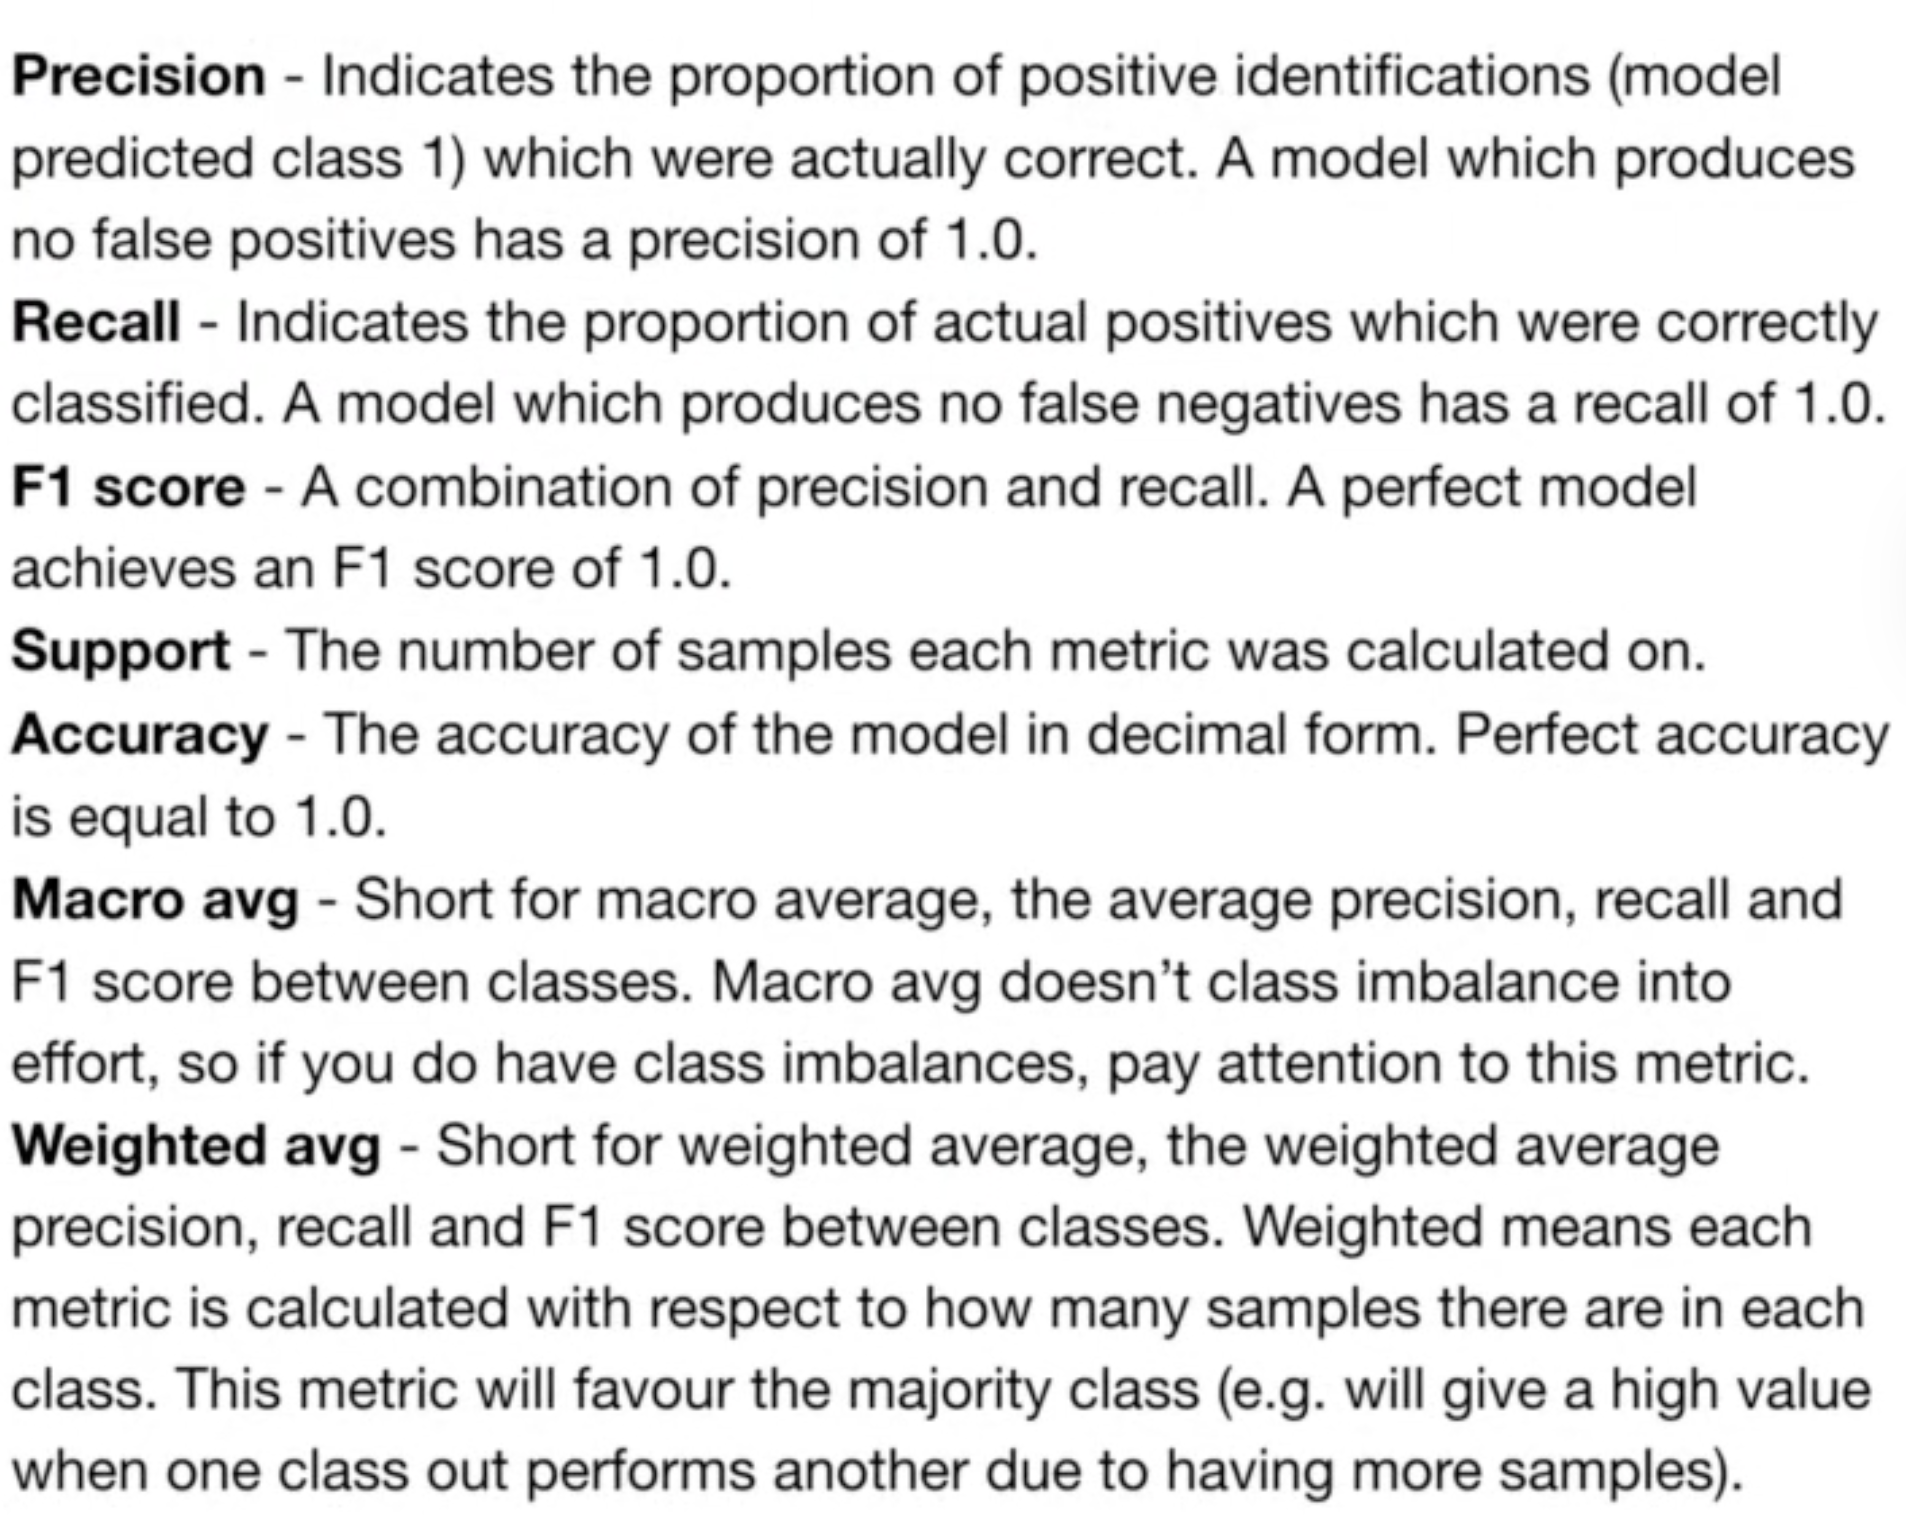

In [44]:
eval_reports = {}
actual_label = test_and_models_df['Actual Label'].values
for ml_model in ml_models:
    ml_model_name = ml_model.get_model_name()
    print(f"Actual Label:\t\t{actual_label}")
    ml_model_predictions = test_and_models_df[ml_model_name].values
    print(f"{ml_model_name}:\t\t{ml_model_predictions}")
    print()
    eval_report = get_metrics.eval_classification_report(y_test_df, ml_model_predictions)
    eval_reports[ml_model_name] = eval_report

Actual Label:		[0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0
 1 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 1 0 0 0 1 1 1 0 0 0 1 0 1
 0 0 1 0 1 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0 1 0 1
 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 0 1 0 1 0 0 1 1
 0 0 0 1 0 0 0 0 0 1 1 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0
 0 0 0 0 1 1 0 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 1 0 1 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1
 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0
 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 1 0 1 0 0 1 1 1 0 0
 0 1 0 1 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0 0 1 0 0 0 0
 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1

In [45]:
eval_reports

{'Perceptron': {'0': {'precision': 0.979381443298969,
   'recall': 0.9571788413098237,
   'f1-score': 0.9681528662420382,
   'support': 397.0},
  '1': {'precision': 0.903954802259887,
   'recall': 0.9523809523809523,
   'f1-score': 0.927536231884058,
   'support': 168.0},
  'accuracy': 0.9557522123893806,
  'macro avg': {'precision': 0.941668122779428,
   'recall': 0.954779896845388,
   'f1-score': 0.947844549063048,
   'support': 565.0},
  'weighted avg': {'precision': 0.9569536987068172,
   'recall': 0.9557522123893806,
   'f1-score': 0.9560757077072759,
   'support': 565.0}},
 'SDG Classifier': {'0': {'precision': 0.9578163771712159,
   'recall': 0.9722921914357683,
   'f1-score': 0.965,
   'support': 397.0},
  '1': {'precision': 0.9320987654320988,
   'recall': 0.8988095238095238,
   'f1-score': 0.9151515151515152,
   'support': 168.0},
  'accuracy': 0.9504424778761061,
  'macro avg': {'precision': 0.9449575713016574,
   'recall': 0.9355508576226461,
   'f1-score': 0.94007575757575

In [46]:
eval_reports_df = pd.DataFrame(eval_reports)
eval_reports_df.to_latex()

"\\begin{tabular}{llllllll}\n\\toprule\n & Perceptron & SDG Classifier & Logistic Regression & Ridge Classifier & Decision Tree & Random Forest & Gradient Boosting Machine \\\\\n\\midrule\n0 & {'precision': 0.979381443298969, 'recall': 0.9571788413098237, 'f1-score': 0.9681528662420382, 'support': 397.0} & {'precision': 0.9578163771712159, 'recall': 0.9722921914357683, 'f1-score': 0.965, 'support': 397.0} & {'precision': 0.9821882951653944, 'recall': 0.9722921914357683, 'f1-score': 0.9772151898734177, 'support': 397.0} & {'precision': 0.9848101265822785, 'recall': 0.9798488664987406, 'f1-score': 0.9823232323232324, 'support': 397.0} & {'precision': 0.8640776699029126, 'recall': 0.8967254408060453, 'f1-score': 0.8800988875154512, 'support': 397.0} & {'precision': 0.9020501138952164, 'recall': 0.9974811083123426, 'f1-score': 0.9473684210526315, 'support': 397.0} & {'precision': 0.9558823529411765, 'recall': 0.982367758186398, 'f1-score': 0.968944099378882, 'support': 397.0} \\\\\n1 & {'p